In [1]:
import pandas as pd
from datetime import datetime, timedelta
import math
import numpy as np
import warnings
from sklearn import linear_model
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")
#allow me to scroll through dataframes without cutting out columns
pd.options.display.max_columns = None
pd.options.mode.chained_assignment = None 

In [2]:
#Need to specify dtype of columns for every csv column for this and every other import

#the players number column, age, weight columns have NaN's in them probably can drop the number and weight columns
#as they are not features 
roster = pd.read_csv('stats_files/rosters', sep = '|')
#makes sure age matches this format and removes players which we don't have a birthdate for
#also excludes weird dates that might include dates over 31 or months over 12 or entries of 00
roster = roster[roster['Birthdate'].str.match('(\d\d\d\d)\-((?!00)0[1-9]|1[0-2])\-((?!00)(0[1-9]|[12]\d|3[01]))')]
#had two birthdates on september 31st just excluded them 
roster = roster[~roster['Birthdate'].str.match('(\d\d\d\d)\-09\-31')]

roster.shape

/Users/MattBarlowe/.virtualenvs/prospectmodel/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (0,2,7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(136018, 13)

In [3]:
#Create the season start to calculate age at start of season for age adjusted statistics
roster['season_start'] = roster['season'].apply(lambda x: x - 1).apply('09-15-{}'.format)
roster['Birthdate'] = pd.to_datetime(roster['Birthdate'], format='%Y-%m-%d')
roster['season_start'] = pd.to_datetime(roster['season_start'], format='%m-%d-%Y')
roster['draft_cutoff'] = roster['season'].apply('09-15-{}'.format)
roster['draft_cutoff'] = pd.to_datetime(roster['draft_cutoff'], format='%m-%d-%Y')
#EP lists players Age as their current age instead of the age they were at the season
#I'm calculating their age as the age they are at the draft cutoff of that season
#in order to see if they are draft eligible that season. I have to calculate the players
#at sept. 15th of the draft year for that respective season. I then use that draft
#cutoff age to determine the years from their first draft eligible year
roster['Age'] = (roster['season_start'] - roster['Birthdate'])
roster['Age'] = roster['Age'] / timedelta(days=365.25)
roster['Age'] = roster['Age'].round(decimals=2)
roster['draft_cutoff_age'] = roster['draft_cutoff'] - roster['Birthdate']
roster['draft_cutoff_age'] = roster['draft_cutoff_age'] / timedelta(days=365.25)
roster['draft_cutoff_age'] = roster['draft_cutoff_age'].round(decimals=3)

In [4]:
#Remove goalies from the dataframe
roster = roster[roster['Position'] != 'G']
roster['Player'] = roster['Player'].str.strip()

In [5]:
#this function determines the years away from first draft eligible year for the season
#of the row i then apply it to the draft_cutoff_age column using pandas .apply() function
def draft_year(age):
    
    if age >=18 and age < 19:
        return 0
    else:
        return math.floor(age-18)
        
        
roster['draft_year'] = roster['draft_cutoff_age'].apply(draft_year)

In [6]:
#Join stats dataframe to the main roster dataframe
stats = pd.read_csv('stats_files/player_stats', sep='|')
stats['Player'] = stats['Player'].str.strip()
stats['team'] = stats['team'].str.strip()
stats = stats.groupby(['Player','season', 'team', 'team_id', 'player_id'], as_index=False).sum()

roster = roster.merge(stats[['player_id', 'season', 'GP', 'G', 'A', 'TP', 'PIM', 'playoff_GP',  
                           'playoff_G', 'playoff_A', 'playoff_TP', 'playoff_PIM', 'playoff_+/-', 'team_id', 'team']], 
                            on = ['player_id', 'season', 'team_id', 'team'])


In [7]:

#converting height into decimal values of feet
def clean_height(value):
    '''
    Function to convert height meausered in feet and inches to a decimal
    value
    Input:
    value - height measured in feet and inches
    Output:
    decimal_value - height returned in feet and inches converted to a decimal
                    value of feet
    '''
    try:
        value = value.replace("'", '.').replace(' ', '').replace('"', '')
        value_list = value.split('.')
        value_list[1] = float(value_list[1])/12
        value = float(value_list[0]) + value_list[1]
        value = round(value, 2)
    except IndexError as ex:
        value = ''

    return value

roster['HT'] = roster['HT'].astype('str').apply(clean_height)


In [8]:
#create goal to total points ratios
roster['goals_to_points'] = roster['G']/roster['TP']
roster['goals_to_points'] = roster['goals_to_points'].fillna(value=0)
roster['goals_to_points'] = roster['goals_to_points'].round(decimals=2)

#create assist to total points ratios
roster['assists_to_points'] = roster['A']/roster['TP']
roster['assists_to_points'] = roster['assists_to_points'].fillna(value=0)
roster['assists_to_points'] = roster['assists_to_points'].round(decimals=2)

#calculate points per game
roster['pts_per_gp'] = roster['TP']/roster['GP']
roster['pts_per_gp'] = roster['pts_per_gp'].fillna(value = 0)
roster['pts_per_gp'] = roster['pts_per_gp'].round(decimals=2)

In [9]:
#joining league data to the dataframe
leagues_hist = pd.read_csv('stats_files/leagues_hist_table', sep='|')

roster = roster.merge(leagues_hist[['league', 'season', 'team_id']], on=['season', 'team_id'])

In [10]:
#reads in draft data and the NHL stats of each drafted player and then joins it to the 
#master dataframe
nhl_draft_data = pd.read_csv('stats_files/nhl_draft_stats', sep='|')

nhl_draft_data = nhl_draft_data.rename(index=str, columns={'G':'nhl_G', 'GP':'nhl_GP', 'A':'nhl_A', 'TP':'nhl_TP'})
roster = roster.merge(nhl_draft_data[['nhl_GP', 'nhl_G', 'nhl_A', 'nhl_TP', 'player_id']], on=['player_id'],
                      how = 'left')
roster = roster.fillna(value=0)

In [11]:
roster.head()

,#,Player,Age,Position,Birthdate,Birthplace,HT,WT,Shots,player_id,team_id,season,team,season_start,draft_cutoff,draft_cutoff_age,draft_year,GP,G,A,TP,PIM,playoff_GP,playoff_G,playoff_A,playoff_TP,playoff_PIM,playoff_+/-,goals_to_points,assists_to_points,pts_per_gp,league,nhl_GP,nhl_G,nhl_A,nhl_TP
0,0,Tommy Albelin,38.32,D,1964-05-21,"Stockholm, SWE",6.08,194,L,701,80,2003,Albany River Rats,2002-09-15,2003-09-15,39.318,21,5,0,2,2,2,0,0,0,0,0,0,0.00,1.00,0.40,AHL,0.0,0,0,0
1,3,Daryl Andrews,25.39,D,1977-04-27,"Campbell River, BC, CAN",6.17,205,L,12221,80,2003,Albany River Rats,2002-09-15,2003-09-15,26.385,8,75,3,6,9,52,0,0,0,0,0,0,0.33,0.67,0.12,AHL,0.0,0,0,0
2,7,Alex Brooks,26.07,D,1976-08-21,"Madison, WI, USA",6.08,194,R,10257,80,2003,Albany River Rats,2002-09-15,2003-09-15,27.066,9,66,0,7,7,56,0,0,0,0,0,0,0.00,1.00,0.11,AHL,0.0,0,0,0
3,0,Phil Cole,20.02,D,1982-09-06,"Winnipeg, MB, CAN",6.33,196,L,15899,80,2003,Albany River Rats,2002-09-15,2003-09-15,21.024,3,4,0,0,0,6,0,0,0,0,0,0,0.00,0.00,0.00,AHL,0.0,0,0,0
4,28,Ray Giroux,26.15,D,1976-07-20,"North Bay, ON, CAN",6.08,190,L,12229,80,2003,Albany River Rats,2002-09-15,2003-09-15,27.154,9,67,11,38,49,49,0,0,0,0,0,0,0.22,0.78,0.73,AHL,0.0,0,0,0


In [12]:
#creating df for age to points regresion stopped at 20 because the regression become negatives as younger players
#graduate to professional leagues
age_adj_score_df = roster[(roster.Age < 20) & (roster.GP >30)]

In [13]:
#splitting into defense and forwards
age_adj_def_df = age_adj_score_df[age_adj_score_df.Position == 'D']
age_adj_fwd_df = age_adj_score_df[age_adj_score_df.Position != 'D']

In [14]:
#graphing the correlation between age and points per game 
import matplotlib.pyplot as plt
ax1 = age_adj_def_df.plot(kind='scatter', x='Age', y='pts_per_gp')
ax2 = age_adj_fwd_df.plot(kind='scatter', x='Age', y='pts_per_gp')
ax1.set_title('Defense')
ax2.set_title('Forwards')
print(ax1)
print(ax2)

AxesSubplot(0.125,0.11;0.775x0.77)
AxesSubplot(0.125,0.11;0.775x0.77)


In [15]:
#getting the coef and yint of the linear regression for points age adj.
def_adj_model = linear_model.LinearRegression()
def_adj_model.fit(age_adj_def_df[['Age']].values, age_adj_def_df['pts_per_gp'].values)
def_model_coef = round(def_adj_model.coef_[0], 3)

fwd_adj_model = linear_model.LinearRegression()
fwd_adj_model.fit(age_adj_fwd_df[['Age']].values, age_adj_fwd_df['pts_per_gp'].values)
fwd_model_coef = round(fwd_adj_model.coef_[0], 3)


/Users/MattBarlowe/.virtualenvs/prospectmodel/lib/python3.6/site-packages/sklearn/linear_model/base.py:509: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  linalg.lstsq(X, y)


In [16]:
#subset main dataframe for only those players in their first draft year and split into forwards and 
#and defnse to calculate age adjusted points per game since players older than 20 will be 
#artificially enhanced by age adjusted points
draft_year_df = roster[(roster['draft_year'] == 0)]
draft_year_df_def = draft_year_df[draft_year_df.Position == 'D']
draft_year_df_fwd = draft_year_df[draft_year_df.Position != 'D']

In [17]:
#creating adjusted pts per game for forwards and defense
draft_year_df_def['age_adj_pts_g'] = (1- ((draft_year_df_def['Age']-17) * def_model_coef)) \
                                        * draft_year_df_def['pts_per_gp']
draft_year_df_fwd['age_adj_pts_g'] = (1- ((draft_year_df_fwd['Age']-17) * fwd_model_coef)) \
                                        * draft_year_df_fwd['pts_per_gp']

#(1 - ([Age as of September of draft year - 17] * 0.1672)) * Pts/GP as from Rhys Jessop formula

In [18]:
#concatting the fwds and def dataframes back together to form the old draft_year_df dataframe
frames = [draft_year_df_def, draft_year_df_fwd]
draft_year_df = pd.concat(frames)
draft_year_df = draft_year_df.fillna(value=0)

In [19]:
#Calculate NHL points per GP and fill NaN with zero for those that have zero NHL GP
draft_year_df.nhl_G = draft_year_df.nhl_G.astype('float')
draft_year_df.nhl_TP = draft_year_df.nhl_TP.astype('float')
draft_year_df.nhl_GP = draft_year_df.nhl_GP.astype('float')
draft_year_df['nhl_pts_per_gp'] = draft_year_df['nhl_TP'] / draft_year_df['nhl_GP']
draft_year_df['nhl_pts_per_gp'] = draft_year_df['nhl_pts_per_gp'].fillna(value=0)

In [20]:
draft_year_df = pd.get_dummies(draft_year_df, columns=['league'])

In [21]:
draft_year_df.head()

,#,Player,Age,Position,Birthdate,Birthplace,HT,WT,Shots,player_id,team_id,season,team,season_start,draft_cutoff,draft_cutoff_age,draft_year,GP,G,A,TP,PIM,playoff_GP,playoff_G,playoff_A,playoff_TP,playoff_PIM,playoff_+/-,goals_to_points,assists_to_points,pts_per_gp,nhl_GP,nhl_G,nhl_A,nhl_TP,age_adj_pts_g,nhl_pts_per_gp,league_Allsvenskan,league_Extraliga,league_KHL,league_Liiga,league_Mestis,league_NCAA,league_OHL,league_QMJHL,league_SHL,league_USDP,league_USHL,league_WHL
18094,6,Stefan Erkgärds,17.48,D,1985-03-23,IK Viking,6.08,192,L,622,25,2003,Bofors IK,2002-09-15,2003-09-15,18.480,0,1,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0
18390,2,Martin Vestberg,17.24,D,1985-06-20,Säters IF,5.92,209,L,2075,29,2003,Mora IK,2002-09-15,2003-09-15,18.237,0,1,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0
18541,16,Daniel Westerlund,17.88,D,1984-10-30,0,6.17,198,L,2205,19,2003,Team Kiruna,2002-09-15,2003-09-15,18.875,0,5,0,0,0,2,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0
18565,12,Erik Josefsson,17.01,D,1985-09-11,Tranås AIF,5.92,190,L,2217,34,2003,Tranås AIF,2002-09-15,2003-09-15,18.010,0,8,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0
18567,28,Johan Magnusson,17.39,D,1985-04-24,Tranås AIF,6.17,220,L,956,34,2003,Tranås AIF,2002-09-15,2003-09-15,18.393,0,35,0,0,0,0,8,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0


In [22]:
#split draft_year_df into one for forwards and defensemen
draft_2018_df = draft_year_df[draft_year_df['season'] == 2018]
draft_year_df = draft_year_df[draft_year_df['season']<2018]
draft_df_fwd = draft_year_df[draft_year_df['Position'] != 'D']
draft_df_def = draft_year_df[draft_year_df['Position'] == 'D']
draft_2018_df_def = draft_2018_df[draft_2018_df['Position'] == 'D']
draft_2018_df_fwd = draft_2018_df[draft_2018_df['Position'] != 'D']

In [23]:
draft_2018_df.head()

,#,Player,Age,Position,Birthdate,Birthplace,HT,WT,Shots,player_id,team_id,season,team,season_start,draft_cutoff,draft_cutoff_age,draft_year,GP,G,A,TP,PIM,playoff_GP,playoff_G,playoff_A,playoff_TP,playoff_PIM,playoff_+/-,goals_to_points,assists_to_points,pts_per_gp,nhl_GP,nhl_G,nhl_A,nhl_TP,age_adj_pts_g,nhl_pts_per_gp,league_Allsvenskan,league_Extraliga,league_KHL,league_Liiga,league_Mestis,league_NCAA,league_OHL,league_QMJHL,league_SHL,league_USDP,league_USHL,league_WHL
25567,47,Filip Andersson,17.75,D,1999-12-14,Smedjebacken HC,6.25,198,L,265669,13,2018,Almtuna IS,2017-09-15,2018-09-15,18.754,0,7,0,0,0,0,3,0,0,0,0,-1,0.00,0.00,0.00,0.0,0.0,0,0.0,0.000000,0.0,1,0,0,0,0,0,0,0,0,0,0,0
25569,97,Adam Boqvist,17.08,D,2000-08-15,Hedemora SK,5.92,170,R,265684,13,2018,Almtuna IS,2017-09-15,2018-09-15,18.084,0,7,0,2,2,2,0,0,0,0,0,0,0.00,1.00,0.29,0.0,0.0,0,0.0,0.288794,0.0,1,0,0,0,0,0,0,0,0,0,0,0
25575,71,Jacob Ragnarsson,17.98,D,1999-09-23,SK Iron,6,176,L,304366,13,2018,Almtuna IS,2017-09-15,2018-09-15,18.979,0,47,4,9,13,24,5,0,0,0,6,-1,0.31,0.69,0.28,0.0,0.0,0,0.0,0.265731,0.0,1,0,0,0,0,0,0,0,0,0,0,0
25713,6,Martin Fehérváry,17.94,D,1999-10-06,SHK Hodonín,6.08,190,L,274991,31,2018,IK Oskarshamn,2017-09-15,2018-09-15,18.943,0,42,1,6,7,24,8,1,2,3,2,4,0.14,0.86,0.17,0.0,0.0,0,0.0,0.161690,0.0,1,0,0,0,0,0,0,0,0,0,0,0
25718,47,Christian Lindberg,17.04,D,2000-08-31,Värmdö HC,6.08,161,L,350782,31,2018,IK Oskarshamn,2017-09-15,2018-09-15,18.040,0,33,0,0,0,2,4,0,0,0,2,1,0.00,0.00,0.00,0.0,0.0,0,0.0,0.000000,0.0,1,0,0,0,0,0,0,0,0,0,0,0


In [24]:
#Determine Forward quartile buckets for GP and pts per game
draft_df_fwd[['GP', 'nhl_pts_per_gp']].quantile([.25, .5, .75, .95, .96, .97, .98, .99])

,GP,nhl_pts_per_gp
0.25,14.0,0.000000
0.50,42.0,0.000000
0.75,60.0,0.000000
0.95,70.0,0.288665
0.96,70.0,0.337484
0.97,71.0,0.421614
0.98,72.0,0.528651
0.99,72.0,0.676620


In [25]:
#Determine Defense quartile buckets for GP and pts per game
#looks like just projecting for the 99th percentile may be the best 
#bet for both GP and points per game in order to find true NHLers
draft_df_def[['GP', 'nhl_pts_per_gp']].quantile([.25, .5, .75, .99])

,GP,nhl_pts_per_gp
0.25,14.0,0.000000
0.50,39.0,0.000000
0.75,59.0,0.000000
0.99,72.0,0.463808


In [26]:
#draft_df_def['>_39_nhl_gp'] = np.where((draft_df_def['nhl_GP'] >=40), 1, 0)
#draft_df_def['>_58_nhl_gp'] = np.where((draft_df_def['nhl_GP'] >=59), 1, 0)
draft_df_def['>_72_nhl_gp'] = np.where((draft_df_def['nhl_GP'] >=72), 1, 0)
draft_df_def['>_.25_nhl_pts_gp'] = np.where((draft_df_def['nhl_pts_per_gp'] >=.25), 1, 0)


In [27]:
draft_df_def.head()

,#,Player,Age,Position,Birthdate,Birthplace,HT,WT,Shots,player_id,team_id,season,team,season_start,draft_cutoff,draft_cutoff_age,draft_year,GP,G,A,TP,PIM,playoff_GP,playoff_G,playoff_A,playoff_TP,playoff_PIM,playoff_+/-,goals_to_points,assists_to_points,pts_per_gp,nhl_GP,nhl_G,nhl_A,nhl_TP,age_adj_pts_g,nhl_pts_per_gp,league_Allsvenskan,league_Extraliga,league_KHL,league_Liiga,league_Mestis,league_NCAA,league_OHL,league_QMJHL,league_SHL,league_USDP,league_USHL,league_WHL,>_72_nhl_gp,>_.25_nhl_pts_gp
18094,6,Stefan Erkgärds,17.48,D,1985-03-23,IK Viking,6.08,192,L,622,25,2003,Bofors IK,2002-09-15,2003-09-15,18.480,0,1,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
18390,2,Martin Vestberg,17.24,D,1985-06-20,Säters IF,5.92,209,L,2075,29,2003,Mora IK,2002-09-15,2003-09-15,18.237,0,1,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
18541,16,Daniel Westerlund,17.88,D,1984-10-30,0,6.17,198,L,2205,19,2003,Team Kiruna,2002-09-15,2003-09-15,18.875,0,5,0,0,0,2,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
18565,12,Erik Josefsson,17.01,D,1985-09-11,Tranås AIF,5.92,190,L,2217,34,2003,Tranås AIF,2002-09-15,2003-09-15,18.010,0,8,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
18567,28,Johan Magnusson,17.39,D,1985-04-24,Tranås AIF,6.17,220,L,956,34,2003,Tranås AIF,2002-09-15,2003-09-15,18.393,0,35,0,0,0,0,8,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [28]:
draft_df_fwd.columns

Index(['#', 'Player', 'Age', 'Position', 'Birthdate', 'Birthplace', 'HT', 'WT',
       'Shots', 'player_id', 'team_id', 'season', 'team', 'season_start',
       'draft_cutoff', 'draft_cutoff_age', 'draft_year', 'GP', 'G', 'A', 'TP',
       'PIM', 'playoff_GP', 'playoff_G', 'playoff_A', 'playoff_TP',
       'playoff_PIM', 'playoff_+/-', 'goals_to_points', 'assists_to_points',
       'pts_per_gp', 'nhl_GP', 'nhl_G', 'nhl_A', 'nhl_TP', 'age_adj_pts_g',
       'nhl_pts_per_gp', 'league_Allsvenskan', 'league_Extraliga',
       'league_KHL', 'league_Liiga', 'league_Mestis', 'league_NCAA',
       'league_OHL', 'league_QMJHL', 'league_SHL', 'league_USDP',
       'league_USHL', 'league_WHL'],
      dtype='object')

In [29]:
draft_df_def[['GP', 'playoff_GP', 'playoff_G', 'playoff_A', 
             'playoff_TP', 'playoff_+/-',
             'goals_to_points', 'assists_to_points',
             'age_adj_pts_g', 'league_Allsvenskan', 
             'league_Extraliga','league_KHL', 'league_Liiga', 
             'league_Mestis', 'league_NCAA', 'league_OHL', 
             'league_QMJHL', 'league_SHL', 
             'league_USHL', 'league_WHL', '>_.25_nhl_pts_gp', '>_72_nhl_gp']].corr()

,GP,playoff_GP,playoff_G,playoff_A,playoff_TP,playoff_+/-,goals_to_points,assists_to_points,age_adj_pts_g,league_Allsvenskan,league_Extraliga,league_KHL,league_Liiga,league_Mestis,league_NCAA,league_OHL,league_QMJHL,league_SHL,league_USHL,league_WHL,>_.25_nhl_pts_gp,>_72_nhl_gp
GP,1.000000,0.498642,0.279062,0.340764,0.350458,-0.009112,0.293732,0.546783,0.388479,-0.205261,-0.158168,-0.102576,-0.105219,-0.118426,-0.024638,0.122070,0.035000,-0.173818,-0.081655,0.186929,0.105602,0.150391
playoff_GP,0.498642,1.000000,0.518231,0.658310,0.670853,0.229456,0.150797,0.246834,0.305095,-0.082110,-0.068595,-0.056451,-0.042453,-0.042678,-0.067106,0.087516,0.061259,-0.051372,-0.107415,0.064127,0.146187,0.181730
playoff_G,0.279062,0.518231,1.000000,0.632914,0.793603,0.226352,0.107703,0.104845,0.403993,-0.042342,-0.038786,-0.025108,-0.029847,-0.021084,-0.029847,0.054526,0.026509,-0.041966,-0.043174,0.024959,0.294401,0.279146
playoff_A,0.340764,0.658310,0.632914,1.000000,0.973347,0.316244,0.104655,0.142149,0.464671,-0.056165,-0.038698,-0.030377,-0.018410,-0.024497,-0.036111,0.076077,0.039921,-0.051444,-0.056987,0.012356,0.286224,0.315949
playoff_TP,0.350458,0.670853,0.793603,0.973347,1.000000,0.315575,0.114148,0.142767,0.484839,-0.056681,-0.041901,-0.031310,-0.023309,-0.025497,-0.037220,0.075938,0.039225,-0.052859,-0.057573,0.017103,0.312141,0.330982
playoff_+/-,-0.009112,0.229456,0.226352,0.316244,0.315575,1.000000,-0.007507,-0.002230,0.038117,0.010637,0.010039,0.004494,0.008007,-0.001129,0.005343,-0.003321,-0.019908,0.000204,0.035838,-0.018829,0.117407,0.059320
goals_to_points,0.293732,0.150797,0.107703,0.104655,0.114148,-0.007507,1.000000,-0.085580,0.252823,-0.070537,-0.088245,-0.041142,-0.039606,-0.033554,0.029190,0.001334,-0.002992,-0.067004,0.080580,0.030647,0.087918,0.093417
assists_to_points,0.546783,0.246834,0.104845,0.142149,0.142767,-0.002230,-0.085580,1.000000,0.384566,-0.177920,-0.147419,-0.084337,-0.095433,-0.069672,0.014161,0.106358,0.005707,-0.160614,0.014787,0.103937,0.033785,0.056588
age_adj_pts_g,0.388479,0.305095,0.403993,0.464671,0.484839,0.038117,0.252823,0.384566,1.000000,-0.102453,-0.102450,-0.061112,-0.048975,-0.027862,0.045178,0.053692,-0.014166,-0.105370,0.074129,0.028255,0.302185,0.303892
league_Allsvenskan,-0.205261,-0.082110,-0.042342,-0.056165,-0.056681,0.010637,-0.070537,-0.177920,-0.102453,1.000000,-0.023670,-0.015323,-0.018215,-0.018509,-0.018215,-0.102765,-0.101076,-0.030789,-0.081157,-0.107029,-0.016380,-0.006012


In [107]:
#Splitting the data into 80/20 train test split with playing more than 50 games as the feature to predict 
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(draft_df_def[['GP', 'G', 'A', 'playoff_GP', 'playoff_G', 'playoff_A', 
                                                                   'playoff_TP', 'playoff_+/-',
                                                                   'goals_to_points', 'assists_to_points',
                                                                    'age_adj_pts_g', 'league_Allsvenskan', 
                                                                   'league_Extraliga','league_KHL', 'league_Liiga', 
                                                                   'league_Mestis', 'league_NCAA', 'league_OHL', 
                                                                   'league_QMJHL', 'league_SHL', 
                                                                   'league_USHL', 'league_WHL']],
                                                    draft_df_def['>_72_nhl_gp'], test_size=0.2
                                                   )

In [108]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(2548, 22) (2548,)
(637, 22) (637,)


In [109]:
#train the logistic regression class_weight='balanced'
from sklearn.linear_model import LogisticRegression
logisticRegr = LogisticRegression(class_weight='balanced')
logisticRegr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

0.8410123966942149


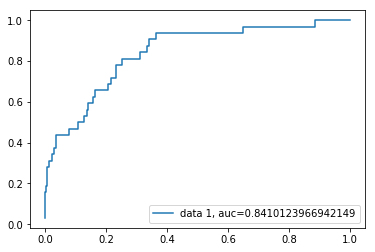

In [110]:
#calculating auc_score for plyaing more than 39 NHL games the median for Defensemen
from sklearn.metrics import roc_auc_score, roc_curve
#get probability scores for each player playing over 50 games in NHL
predictions = logisticRegr.predict(X_test)
y_pred_proba =  logisticRegr.predict_proba(X_test)[:,1]
auc = roc_auc_score(y_test, y_pred_proba)
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
print(auc)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [111]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, predictions)

array([[496, 109],
       [ 11,  21]])

In [112]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(X_train, y_train)
gnb_pred = gnb.predict(X_test)
confusion_matrix(y_test, gnb_pred)

array([[541,  64],
       [ 16,  16]])

0.8239669421487604


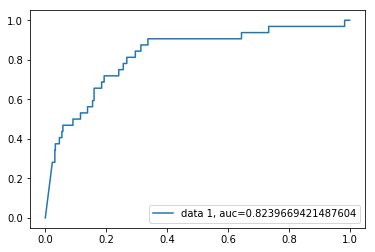

In [113]:
#naive bayes predictor
gnb_predictions = gnb.predict(X_test)
y_pred_prob_gnb =  gnb.predict_proba(X_test)[:,1]
auc = roc_auc_score(y_test, y_pred_prob_gnb)
fpr, tpr, _ = roc_curve(y_test,  y_pred_prob_gnb)
print(auc)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [114]:
from sklearn.ensemble import RandomForestClassifier as RandomForest

tree = RandomForest(
    n_jobs= -1,
    n_estimators= 500,
     #warm_start= True, 
     #'max_features': 0.2,
    max_depth= 6,
    min_samples_leaf= 2,
    max_features = 'sqrt',
    verbose=0,
    class_weight='balanced'
)
tree.fit(X_train, y_train)
tree_pred = tree.predict(X_test)
confusion_matrix(y_test, tree_pred)

array([[541,  64],
       [ 15,  17]])

0.7951446280991736


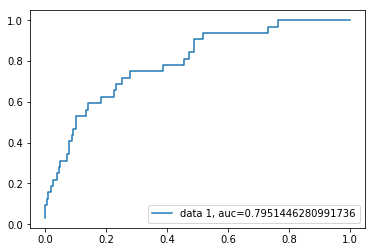

In [115]:
#random forest predictor
tree_predictions = tree.predict(X_test)
y_pred_prob_tree =  tree.predict_proba(X_test)[:,1]
auc = roc_auc_score(y_test, y_pred_prob_tree)
fpr, tpr, _ = roc_curve(y_test,  y_pred_prob_tree)
print(auc)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [116]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=5)
dt.fit(X_train, y_train)
dt_pred = dt.predict(X_test)
confusion_matrix(y_test, dt_pred)

array([[466, 139],
       [ 10,  22]])

0.7398760330578512


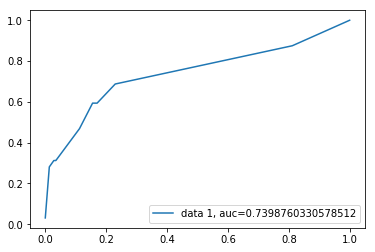

In [117]:
#SVM
dt_predictions = dt.predict(X_test)
y_pred_prob_dt =  dt.predict_proba(X_test)[:,1]
auc = roc_auc_score(y_test, y_pred_prob_dt)
fpr, tpr, _ = roc_curve(y_test,  y_pred_prob_dt)
print(auc)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [119]:
#calculate SVM prediction probabilities
predictions = dt.predict_proba(draft_df_def[['GP', 'G', 'A', 'playoff_GP', 'playoff_G', 'playoff_A', 
                                                                   'playoff_TP', 'playoff_+/-',
                                                                   'goals_to_points', 'assists_to_points',
                                                                    'age_adj_pts_g', 'league_Allsvenskan', 
                                                                   'league_Extraliga','league_KHL', 'league_Liiga', 
                                                                   'league_Mestis', 'league_NCAA', 'league_OHL', 
                                                                   'league_QMJHL', 'league_SHL', 
                                                                   'league_USHL', 'league_WHL']])[:,1]
#draft_2018_df = draft_df_def[(draft_df_def['draft_year'] == 0) & (draft_df_def['season'] == 2018) & (roster['Position'] == 'D')]
predictions_2018 = dt.predict_proba(draft_2018_df_def[['GP', 'G', 'A', 'playoff_GP', 'playoff_G', 'playoff_A', 
                                                                   'playoff_TP', 'playoff_+/-',
                                                                   'goals_to_points', 'assists_to_points',
                                                                    'age_adj_pts_g', 'league_Allsvenskan', 
                                                                   'league_Extraliga','league_KHL', 'league_Liiga', 
                                                                   'league_Mestis', 'league_NCAA', 'league_OHL', 
                                                                   'league_QMJHL', 'league_SHL', 
                                                                   'league_USHL', 'league_WHL']])[:,1]

draft_df_def['>_72_nhl_gp_game_dt'] = predictions
draft_2018_df_def['>_72_nhl_gp_game_dt'] = predictions_2018

In [120]:
predictions


array([0.93173069, 0.93173069, 0.93173069, ..., 0.        , 0.        ,
       0.88046167])

In [121]:
#calculate random forest prediction probabilities
predictions = tree.predict_proba(draft_df_def[['GP', 'G', 'A', 'playoff_GP', 'playoff_G', 'playoff_A', 
                                                                   'playoff_TP', 'playoff_+/-',
                                                                   'goals_to_points', 'assists_to_points',
                                                                    'age_adj_pts_g', 'league_Allsvenskan', 
                                                                   'league_Extraliga','league_KHL', 'league_Liiga', 
                                                                   'league_Mestis', 'league_NCAA', 'league_OHL', 
                                                                   'league_QMJHL', 'league_SHL', 
                                                                   'league_USHL', 'league_WHL']])[:,1]
#draft_2018_df = draft_df_def[(draft_df_def['draft_year'] == 0) & (draft_df_def['season'] == 2018) & (roster['Position'] == 'D')]
predictions_2018 = tree.predict_proba(draft_2018_df_def[['GP', 'G', 'A', 'playoff_GP', 'playoff_G', 'playoff_A', 
                                                                   'playoff_TP', 'playoff_+/-',
                                                                   'goals_to_points', 'assists_to_points',
                                                                    'age_adj_pts_g', 'league_Allsvenskan', 
                                                                   'league_Extraliga','league_KHL', 'league_Liiga', 
                                                                   'league_Mestis', 'league_NCAA', 'league_OHL', 
                                                                   'league_QMJHL', 'league_SHL', 
                                                                   'league_USHL', 'league_WHL']])[:,1]

draft_df_def['>_72_nhl_gp_game_tree'] = predictions
draft_2018_df_def['>_72_nhl_gp_game_tree'] = predictions_2018

In [122]:
#calculate random forest prediction probabilities
predictions = gnb.predict_proba(draft_df_def[['GP', 'G', 'A', 'playoff_GP', 'playoff_G', 'playoff_A', 
                                                                   'playoff_TP', 'playoff_+/-',
                                                                   'goals_to_points', 'assists_to_points',
                                                                    'age_adj_pts_g', 'league_Allsvenskan', 
                                                                   'league_Extraliga','league_KHL', 'league_Liiga', 
                                                                   'league_Mestis', 'league_NCAA', 'league_OHL', 
                                                                   'league_QMJHL', 'league_SHL', 
                                                                   'league_USHL', 'league_WHL']])[::,1]
#draft_2018_df = draft_df_def[(draft_df_def['draft_year'] == 0) & (draft_df_def['season'] == 2018) & (roster['Position'] == 'D')]
predictions_2018 = gnb.predict_proba(draft_2018_df_def[['GP', 'G', 'A', 'playoff_GP', 'playoff_G', 'playoff_A', 
                                                                   'playoff_TP', 'playoff_+/-',
                                                                   'goals_to_points', 'assists_to_points',
                                                                    'age_adj_pts_g', 'league_Allsvenskan', 
                                                                   'league_Extraliga','league_KHL', 'league_Liiga', 
                                                                   'league_Mestis', 'league_NCAA', 'league_OHL', 
                                                                   'league_QMJHL', 'league_SHL', 
                                                                   'league_USHL', 'league_WHL']])[:,1]
draft_df_def['>_72_nhl_gp_game_gnb'] = predictions
draft_2018_df_def['>_72_nhl_gp_game_gnb'] = predictions_2018

In [123]:
#calculate random forest prediction probabilities
predictions = logisticRegr.predict_proba(draft_df_def[['GP', 'G', 'A', 'playoff_GP', 'playoff_G', 'playoff_A', 
                                                                   'playoff_TP', 'playoff_+/-',
                                                                   'goals_to_points', 'assists_to_points',
                                                                    'age_adj_pts_g', 'league_Allsvenskan', 
                                                                   'league_Extraliga','league_KHL', 'league_Liiga', 
                                                                   'league_Mestis', 'league_NCAA', 'league_OHL', 
                                                                   'league_QMJHL', 'league_SHL', 
                                                                   'league_USHL', 'league_WHL']])[:,1]
#draft_2018_df = draft_df_def[(draft_df_def['draft_year'] == 0) & (draft_df_def['season'] == 2018) & (roster['Position'] == 'D')]
predictions_2018 = logisticRegr.predict_proba(draft_2018_df_def[['GP', 'G', 'A', 'playoff_GP', 'playoff_G', 'playoff_A', 
                                                                   'playoff_TP', 'playoff_+/-',
                                                                   'goals_to_points', 'assists_to_points',
                                                                    'age_adj_pts_g', 'league_Allsvenskan', 
                                                                   'league_Extraliga','league_KHL', 'league_Liiga', 
                                                                   'league_Mestis', 'league_NCAA', 'league_OHL', 
                                                                   'league_QMJHL', 'league_SHL', 
                                                                   'league_USHL', 'league_WHL']])[:,1]
draft_df_def['>_72_nhl_gp_game_log'] = predictions
draft_2018_df_def['>_72_nhl_gp_game_log'] = predictions_2018

Text(0.5,0,'nhl_pts_per_gp')

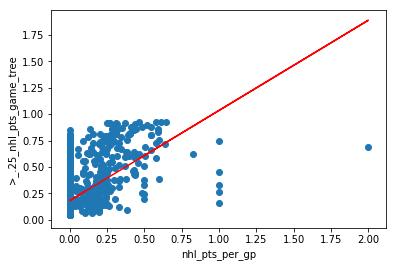

In [124]:
fig, ax = plt.subplots()
fit = np.polyfit(draft_df_def['nhl_pts_per_gp'], draft_df_def['>_.25_nhl_pts_game_tree'], deg=1)
ax.plot(draft_df_def['nhl_pts_per_gp'], fit[0] * draft_df_def['nhl_pts_per_gp'] + fit[1], color='red')
ax.scatter(draft_df_def['nhl_pts_per_gp'], draft_df_def['>_.25_nhl_pts_game_tree'])
plt.ylabel('>_.25_nhl_pts_game_tree')
plt.xlabel('nhl_pts_per_gp')

In [125]:
draft_2018_df_def['model_average_games'] = draft_2018_df_def[['>_72_nhl_gp_game_log', '>_72_nhl_gp_game_gnb', 
                                                        '>_72_nhl_gp_game_tree', '>_72_nhl_gp_game_dt'
]].mean(axis=1)
draft_2018_df_def = draft_2018_df_def.sort_values(['model_average'], ascending=False)


In [126]:
draft_2018_df_def[['Player', '>_72_nhl_gp_game_log', '>_72_nhl_gp_game_gnb', 
                   '>_72_nhl_gp_game_tree', '>_72_nhl_gp_game_dt','model_average']].head(20)

,Player,>_72_nhl_gp_game_log,>_72_nhl_gp_game_gnb,>_72_nhl_gp_game_tree,>_72_nhl_gp_game_dt,model_average
96756,Nicolas Beaudin,0.990871,1.000000,0.860601,0.931731,0.945801
120697,Ty Smith,0.996535,1.000000,0.846684,0.931731,0.943737
88091,Rasmus Sandin,0.994956,1.000000,0.776034,0.931731,0.925680
87814,Evan Bouchard,0.999471,1.000000,0.770190,0.931731,0.925348
120347,Calen Addison,0.999380,1.000000,0.762696,0.931731,0.923452
96573,Noah Dobson,0.990889,1.000000,0.741689,0.931731,0.916077
103262,Bode Wilde,0.953761,0.960666,0.804797,0.931731,0.912739
87704,Ryan Merkley,0.997704,1.000000,0.714655,0.931731,0.911022
78857,Quinn Hughes,0.956222,1.000000,0.725870,0.931731,0.903456
120553,Alexander Alexeyev,0.923823,0.999954,0.731243,0.931731,0.896688


In [127]:
draft_rankings_2018 = draft_2018_df_def[['Player', 'model_average']].groupby(['Player'], as_index=False).mean().sort_values(['model_average'], ascending=False)

In [128]:
draft_rankings_2018.head(30)

,Player,model_average
147,Nicolas Beaudin,0.945801
189,Ty Smith,0.943737
61,Evan Bouchard,0.925348
28,Calen Addison,0.923452
150,Noah Dobson,0.916077
166,Ryan Merkley,0.911022
159,Quinn Hughes,0.903456
11,Alexander Alexeyev,0.896688
92,Jared McIsaac,0.880101
160,Rasmus Dahlin,0.855341


In [133]:
draft_df_def['model_average_>_.25'] = draft_df_def[['>_.25_nhl_pts_game_log', '>_.25_nhl_pts_game_gnb', 
                                                        '>_.25_nhl_pts_game_tree', '>_.25_nhl_pts_game_dt'
]].mean(axis=1)

draft_df_def['model_average_>_72_games']= draft_df_def[['>_72_nhl_gp_game_log', '>_72_nhl_gp_game_gnb', 
               '>_72_nhl_gp_game_tree', '>_72_nhl_gp_game_dt']].mean(axis=1)
draft_df_def = draft_df_def.sort_values(['model_average_>_.25'], ascending=False)

In [135]:
draft_rankings = draft_df_def[['Player', 'model_average_>_.25','model_average_>_72_games']].groupby(['Player'], as_index=False).mean().sort_values(['model_average_>_.25'], ascending=False)

In [136]:
draft_rankings.head(30)

,Player,model_average_>_.25,model_average_>_72_games
2510,Seth Jones,0.967596,0.962575
2790,Tyson Barrie,0.967329,0.952929
2196,P.K. Subban,0.965285,0.962984
755,Derrick Pouliot,0.964269,0.960190
524,Cody Ceci,0.964048,0.969103
400,Cam Barker,0.963627,0.958741
772,Dmitri Kulikov,0.963401,0.950440
2377,Ryan Ellis,0.962959,0.963990
66,Alex Pietrangelo,0.962599,0.957664
1943,Michael Del Zotto,0.962315,0.963586


In [137]:
#repeating process for forwards
draft_df_fwd['>_72_nhl_gp'] = np.where((draft_df_fwd['nhl_GP'] >=72), 1, 0)
draft_df_fwd['>_.42_nhl_pts_gp'] = np.where((draft_df_fwd['nhl_pts_per_gp'] >=.42), 1, 0)

X_train_gp, X_test_gp, y_train_gp, y_test_gp = train_test_split(draft_df_fwd[['GP', 'G', 'A', 'playoff_GP', 'playoff_G', 'playoff_A', 
                                                                   'playoff_TP', 'playoff_+/-',
                                                                   'goals_to_points', 'assists_to_points',
                                                                    'age_adj_pts_g', 'league_Allsvenskan', 
                                                                   'league_Extraliga','league_KHL', 'league_Liiga', 
                                                                   'league_Mestis', 'league_NCAA', 'league_OHL', 
                                                                   'league_QMJHL', 'league_SHL', 
                                                                   'league_USHL', 'league_WHL']],
                                                    draft_df_fwd['>_72_nhl_gp'], test_size=0.2)

X_train_pts, X_test_pts, y_train_pts, y_test_pts = train_test_split(draft_df_fwd[['GP', 'G', 'A', 'playoff_GP', 'playoff_G', 'playoff_A', 
                                                                   'playoff_TP', 'playoff_+/-',
                                                                   'goals_to_points', 'assists_to_points',
                                                                    'age_adj_pts_g', 'league_Allsvenskan', 
                                                                   'league_Extraliga','league_KHL', 'league_Liiga', 
                                                                   'league_Mestis', 'league_NCAA', 'league_OHL', 
                                                                   'league_QMJHL', 'league_SHL', 
                                                                   'league_USHL', 'league_WHL']],
                                                    draft_df_fwd['>_.42_nhl_pts_gp'], test_size=0.2)

In [138]:
#Fit log reg to both classes
logreggames = LogisticRegression(class_weight='balanced')
logregpoints = LogisticRegression(class_weight='balanced')
logreggames.fit(X_train_gp, y_train_gp)
logregpoints.fit(X_train_gp, y_train_gp)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

0.8856194054364787


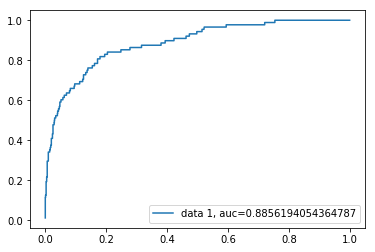

In [143]:
#get logreg probability scores for each player playing over 72 games in NHL
predict_gp = logreggames.predict(X_test_gp)
y_pred_proba_gp =  logreggames.predict_proba(X_test_gp)[:,1]
auc = roc_auc_score(y_test_gp, y_pred_proba_gp)
fpr, tpr, _ = roc_curve(y_test_gp,  y_pred_proba_gp)
print(auc)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

0.9445871385083714


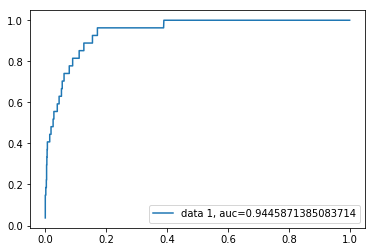

In [166]:
#get logreg probability scores for each player scoring over .42 pts per game in NHL
predict_pts = logregpoints.predict(X_test_pts)
y_pred_proba_pts =  logregpoints.predict_proba(X_test_pts)[:,1]
auc = roc_auc_score(y_test_pts, y_pred_proba_pts)
fpr, tpr, _ = roc_curve(y_test_pts,  y_pred_proba_pts)
print(auc)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [145]:
confusion_matrix(y_test_gp, predict_gp)

array([[927, 180],
       [ 19,  69]])

In [146]:
confusion_matrix(y_test_pts, predict_pts)

array([[954, 214],
       [  1,  26]])

In [207]:
from sklearn.naive_bayes import GaussianNB
gnb_pts = GaussianNB()
gnb_gp = GaussianNB()
gnb_pts.fit(X_train_pts, y_train_pts)
gnb_gp.fit(X_train_gp, y_train_gp)
gnb_pts_pred = gnb.predict(X_test_pts)
gnb_gp_pred = gnb.predict(X_test_gp)


In [148]:
confusion_matrix(y_test_gp, gnb_gp_pred)

array([[853, 254],
       [ 20,  68]])

In [149]:
confusion_matrix(y_test_pts, gnb_pts_pred)

array([[866, 302],
       [  7,  20]])

0.8119508089020284


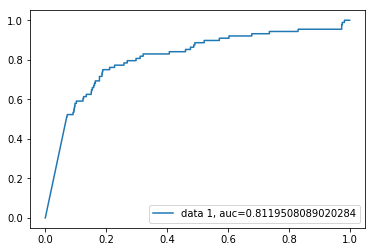

In [150]:
#get GNB probability scores for each player playing over 72 games in NHL
gnb_gp_pred = gnb.predict(X_test_gp)
y_pred_proba_gp = gnb.predict_proba(X_test_gp)[:,1]
auc = roc_auc_score(y_test_gp, y_pred_proba_gp)
fpr, tpr, _ = roc_curve(y_test_gp,  y_pred_proba_gp)
print(auc)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

0.7671232876712327


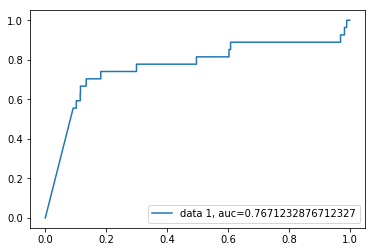

In [151]:
#get GNB probability scores for each player scoring over .42 points per games in NHL
gnb_pts_pred = gnb.predict(X_test_pts)
y_pred_proba_pts = gnb.predict_proba(X_test_pts)[:,1]
auc = roc_auc_score(y_test_pts, y_pred_proba_pts)
fpr, tpr, _ = roc_curve(y_test_pts,  y_pred_proba_pts)
print(auc)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [173]:
tree_pts = RandomForest(
    n_jobs= -1,
    n_estimators= 500,
     #warm_start= True, 
     #'max_features': 0.2,
    max_depth= 6,
    min_samples_leaf= 2,
    max_features = 'sqrt',
    verbose=0,
    class_weight='balanced')

tree_gp = RandomForest(n_jobs= -1, n_estimators= 500,
                       #warm_start= True, 
                       #'max_features': 0.2,
                       max_depth= 6, min_samples_leaf= 2, max_features = 'sqrt',
                       verbose=0, class_weight='balanced')

tree_pts.fit(X_train_pts, y_train_pts)
tree_gp.fit(X_train_gp, y_train_gp)
tree_pts_pred = gnb.predict(X_test_pts)
tree_gp_pred = gnb.predict(X_test_gp)

In [154]:
confusion_matrix(y_test_gp, tree_gp_pred)

array([[853, 254],
       [ 20,  68]])

In [155]:
confusion_matrix(y_test_pts, tree_pts_pred)

array([[866, 302],
       [  7,  20]])

0.8415301387862363


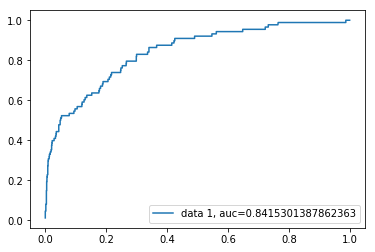

In [156]:
#get Random Forest probability scores for each forward playing over 72 games in NHL
tree_gp_pred = tree.predict(X_test_gp)
y_pred_proba_gp = tree.predict_proba(X_test_gp)[:,1]
auc = roc_auc_score(y_test_gp, y_pred_proba_gp)
fpr, tpr, _ = roc_curve(y_test_gp,  y_pred_proba_gp)
print(auc)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

0.8521213850837138


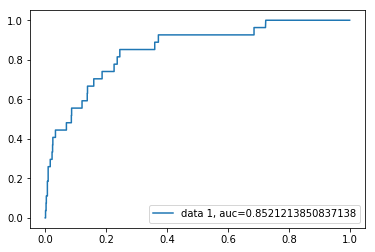

In [157]:
#get Random Forest probability scores for each forward scoring over .42 points per games in NHL
tree_pts = tree.predict(X_test_pts)
y_pred_proba_pts = tree.predict_proba(X_test_pts)[:,1]
auc = roc_auc_score(y_test_pts, y_pred_proba_pts)
fpr, tpr, _ = roc_curve(y_test_pts,  y_pred_proba_pts)
print(auc)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [158]:
from sklearn.tree import DecisionTreeClassifier

dt_pts = DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=5)
dt_gp = DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=5)
dt_pts.fit(X_train_pts, y_train_pts)
dt_gp.fit(X_train_gp, y_train_gp)
dt_pred_pts = dt.predict(X_test_pts)
dt_pred_gp = dt.predict(X_test_gp)


In [159]:
confusion_matrix(y_test_pts, dt_pred_pts)

array([[630, 538],
       [  2,  25]])

In [160]:
confusion_matrix(y_test_gp, dt_pred_gp)

array([[588, 519],
       [ 11,  77]])

0.7855793709452246


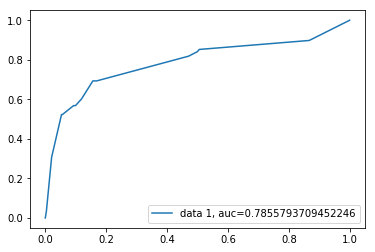

In [162]:
#Decision Tree for games played more than 72 in the NHL
dt_pred_gp = dt_gp.predict(X_test_gp)
y_pred_prob_dt_gp =  dt_gp.predict_proba(X_test_gp)[:,1]
auc = roc_auc_score(y_test_gp, y_pred_prob_dt_gp)
fpr, tpr, _ = roc_curve(y_test_gp,  y_pred_prob_dt_gp)
print(auc)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

0.7485413495687467


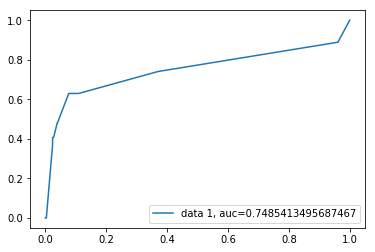

In [163]:
#Decision Tree for games played more than 72 in the NHL
dt_pred_pts = dt_pts.predict(X_test_pts)
y_pred_prob_dt_pts =  dt_pts.predict_proba(X_test_pts)[:,1]
auc = roc_auc_score(y_test_pts, y_pred_prob_dt_pts)
fpr, tpr, _ = roc_curve(y_test_pts,  y_pred_prob_dt_pts)
print(auc)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [220]:
#calculate SVM prediction probabilities
predictions = dt_gp.predict_proba(draft_df_fwd[['GP', 'G', 'A', 'playoff_GP', 'playoff_G', 'playoff_A', 
                                                                   'playoff_TP', 'playoff_+/-',
                                                                   'goals_to_points', 'assists_to_points',
                                                                    'age_adj_pts_g', 'league_Allsvenskan', 
                                                                   'league_Extraliga','league_KHL', 'league_Liiga', 
                                                                   'league_Mestis', 'league_NCAA', 'league_OHL', 
                                                                   'league_QMJHL', 'league_SHL', 
                                                                   'league_USHL', 'league_WHL']])[:,1]
#draft_2018_df = draft_df_def[(draft_df_def['draft_year'] == 0) & (draft_df_def['season'] == 2018) & (roster['Position'] == 'D')]
predictions_2018 = dt_gp.predict_proba(draft_2018_df_fwd[['GP', 'G', 'A', 'playoff_GP', 'playoff_G', 'playoff_A', 
                                                                   'playoff_TP', 'playoff_+/-',
                                                                   'goals_to_points', 'assists_to_points',
                                                                    'age_adj_pts_g', 'league_Allsvenskan', 
                                                                   'league_Extraliga','league_KHL', 'league_Liiga', 
                                                                   'league_Mestis', 'league_NCAA', 'league_OHL', 
                                                                   'league_QMJHL', 'league_SHL', 
                                                                   'league_USHL', 'league_WHL']])[:,1]

draft_df_fwd['>_72_nhl_gp_game_dt'] = predictions
draft_2018_df_fwd['>_72_nhl_gp_game_dt'] = predictions_2018

In [221]:
#calculate random forest prediction probabilities
predictions = tree_gp.predict_proba(draft_df_fwd[['GP', 'G', 'A', 'playoff_GP', 'playoff_G', 'playoff_A', 
                                                                   'playoff_TP', 'playoff_+/-',
                                                                   'goals_to_points', 'assists_to_points',
                                                                    'age_adj_pts_g', 'league_Allsvenskan', 
                                                                   'league_Extraliga','league_KHL', 'league_Liiga', 
                                                                   'league_Mestis', 'league_NCAA', 'league_OHL', 
                                                                   'league_QMJHL', 'league_SHL', 
                                                                   'league_USHL', 'league_WHL']])[:,1]
#draft_2018_df = draft_df_def[(draft_df_def['draft_year'] == 0) & (draft_df_def['season'] == 2018) & (roster['Position'] == 'D')]
predictions_2018 = tree_gp.predict_proba(draft_2018_df_fwd[['GP', 'G', 'A', 'playoff_GP', 'playoff_G', 'playoff_A', 
                                                                   'playoff_TP', 'playoff_+/-',
                                                                   'goals_to_points', 'assists_to_points',
                                                                    'age_adj_pts_g', 'league_Allsvenskan', 
                                                                   'league_Extraliga','league_KHL', 'league_Liiga', 
                                                                   'league_Mestis', 'league_NCAA', 'league_OHL', 
                                                                   'league_QMJHL', 'league_SHL', 
                                                                   'league_USHL', 'league_WHL']])[:,1]

draft_df_fwd['>_72_nhl_gp_game_tree'] = predictions
draft_2018_df_fwd['>_72_nhl_gp_game_tree'] = predictions_2018




In [222]:
#calculate random forest prediction probabilities
predictions = gnb_gp.predict_proba(draft_df_fwd[['GP', 'G', 'A', 'playoff_GP', 'playoff_G', 'playoff_A', 
                                                                   'playoff_TP', 'playoff_+/-',
                                                                   'goals_to_points', 'assists_to_points',
                                                                    'age_adj_pts_g', 'league_Allsvenskan', 
                                                                   'league_Extraliga','league_KHL', 'league_Liiga', 
                                                                   'league_Mestis', 'league_NCAA', 'league_OHL', 
                                                                   'league_QMJHL', 'league_SHL', 
                                                                   'league_USHL', 'league_WHL']])[:,1]
#draft_2018_df = draft_df_def[(draft_df_def['draft_year'] == 0) & (draft_df_def['season'] == 2018) & (roster['Position'] == 'D')]
predictions_2018 = gnb_gp.predict_proba(draft_2018_df_fwd[['GP', 'G', 'A', 'playoff_GP', 'playoff_G', 'playoff_A', 
                                                                   'playoff_TP', 'playoff_+/-',
                                                                   'goals_to_points', 'assists_to_points',
                                                                    'age_adj_pts_g', 'league_Allsvenskan', 
                                                                   'league_Extraliga','league_KHL', 'league_Liiga', 
                                                                   'league_Mestis', 'league_NCAA', 'league_OHL', 
                                                                   'league_QMJHL', 'league_SHL', 
                                                                   'league_USHL', 'league_WHL']])[:,1]
draft_df_fwd['>_72_nhl_gp_game_gnb'] = predictions
draft_2018_df_fwd['>_72_nhl_gp_game_gnb'] = predictions_2018


In [224]:
#calculate random forest prediction probabilities
predictions = logreggames.predict_proba(draft_df_fwd[['GP', 'G', 'A', 'playoff_GP', 'playoff_G', 'playoff_A', 
                                                                   'playoff_TP', 'playoff_+/-',
                                                                   'goals_to_points', 'assists_to_points',
                                                                    'age_adj_pts_g', 'league_Allsvenskan', 
                                                                   'league_Extraliga','league_KHL', 'league_Liiga', 
                                                                   'league_Mestis', 'league_NCAA', 'league_OHL', 
                                                                   'league_QMJHL', 'league_SHL', 
                                                                   'league_USHL', 'league_WHL']])[:,1]
#draft_2018_df = draft_df_def[(draft_df_def['draft_year'] == 0) & (draft_df_def['season'] == 2018) & (roster['Position'] == 'D')]
predictions_2018 = logreggames.predict_proba(draft_2018_df_fwd[['GP', 'G', 'A', 'playoff_GP', 'playoff_G', 'playoff_A', 
                                                                   'playoff_TP', 'playoff_+/-',
                                                                   'goals_to_points', 'assists_to_points',
                                                                    'age_adj_pts_g', 'league_Allsvenskan', 
                                                                   'league_Extraliga','league_KHL', 'league_Liiga', 
                                                                   'league_Mestis', 'league_NCAA', 'league_OHL', 
                                                                   'league_QMJHL', 'league_SHL', 
                                                                   'league_USHL', 'league_WHL']])[:,1]
draft_df_fwd['>_72_nhl_gp_game_log'] = predictions
draft_2018_df_fwd['>_72_nhl_gp_game_log'] = predictions_2018

In [225]:
#calculate SVM prediction probabilities
predictions = dt_pts.predict_proba(draft_df_fwd[['GP', 'G', 'A', 'playoff_GP', 'playoff_G', 'playoff_A', 
                                                                   'playoff_TP', 'playoff_+/-',
                                                                   'goals_to_points', 'assists_to_points',
                                                                    'age_adj_pts_g', 'league_Allsvenskan', 
                                                                   'league_Extraliga','league_KHL', 'league_Liiga', 
                                                                   'league_Mestis', 'league_NCAA', 'league_OHL', 
                                                                   'league_QMJHL', 'league_SHL', 
                                                                   'league_USHL', 'league_WHL']])[:,1]
#draft_2018_df = draft_df_def[(draft_df_def['draft_year'] == 0) & (draft_df_def['season'] == 2018) & (roster['Position'] == 'D')]
predictions_2018 = dt_pts.predict_proba(draft_2018_df_fwd[['GP', 'G', 'A', 'playoff_GP', 'playoff_G', 'playoff_A', 
                                                                   'playoff_TP', 'playoff_+/-',
                                                                   'goals_to_points', 'assists_to_points',
                                                                    'age_adj_pts_g', 'league_Allsvenskan', 
                                                                   'league_Extraliga','league_KHL', 'league_Liiga', 
                                                                   'league_Mestis', 'league_NCAA', 'league_OHL', 
                                                                   'league_QMJHL', 'league_SHL', 
                                                                   'league_USHL', 'league_WHL']])[:,1]

draft_df_fwd['>_.42_nhl_pts_game_dt'] = predictions
draft_2018_df_fwd['>_.42_nhl_pts_game_dt'] = predictions_2018

#calculate random forest prediction probabilities
predictions = tree_pts.predict_proba(draft_df_fwd[['GP', 'G', 'A', 'playoff_GP', 'playoff_G', 'playoff_A', 
                                                                   'playoff_TP', 'playoff_+/-',
                                                                   'goals_to_points', 'assists_to_points',
                                                                    'age_adj_pts_g', 'league_Allsvenskan', 
                                                                   'league_Extraliga','league_KHL', 'league_Liiga', 
                                                                   'league_Mestis', 'league_NCAA', 'league_OHL', 
                                                                   'league_QMJHL', 'league_SHL', 
                                                                   'league_USHL', 'league_WHL']])[:,1]
#draft_2018_df = draft_df_def[(draft_df_def['draft_year'] == 0) & (draft_df_def['season'] == 2018) & (roster['Position'] == 'D')]
predictions_2018 = tree_pts.predict_proba(draft_2018_df_fwd[['GP', 'G', 'A', 'playoff_GP', 'playoff_G', 'playoff_A', 
                                                                   'playoff_TP', 'playoff_+/-',
                                                                   'goals_to_points', 'assists_to_points',
                                                                    'age_adj_pts_g', 'league_Allsvenskan', 
                                                                   'league_Extraliga','league_KHL', 'league_Liiga', 
                                                                   'league_Mestis', 'league_NCAA', 'league_OHL', 
                                                                   'league_QMJHL', 'league_SHL', 
                                                                   'league_USHL', 'league_WHL']])[:,1]

draft_df_fwd['>_.42_nhl_pts_game_tree'] = predictions
draft_2018_df_fwd['>_.42_nhl_pts_game_tree'] = predictions_2018




#calculate random forest prediction probabilities
predictions = gnb_pts.predict_proba(draft_df_fwd[['GP', 'G', 'A', 'playoff_GP', 'playoff_G', 'playoff_A', 
                                                                   'playoff_TP', 'playoff_+/-',
                                                                   'goals_to_points', 'assists_to_points',
                                                                    'age_adj_pts_g', 'league_Allsvenskan', 
                                                                   'league_Extraliga','league_KHL', 'league_Liiga', 
                                                                   'league_Mestis', 'league_NCAA', 'league_OHL', 
                                                                   'league_QMJHL', 'league_SHL', 
                                                                   'league_USHL', 'league_WHL']])[:,1]
#draft_2018_df = draft_df_def[(draft_df_def['draft_year'] == 0) & (draft_df_def['season'] == 2018) & (roster['Position'] == 'D')]
predictions_2018 = gnb_pts.predict_proba(draft_2018_df_fwd[['GP', 'G', 'A', 'playoff_GP', 'playoff_G', 'playoff_A', 
                                                                   'playoff_TP', 'playoff_+/-',
                                                                   'goals_to_points', 'assists_to_points',
                                                                    'age_adj_pts_g', 'league_Allsvenskan', 
                                                                   'league_Extraliga','league_KHL', 'league_Liiga', 
                                                                   'league_Mestis', 'league_NCAA', 'league_OHL', 
                                                                   'league_QMJHL', 'league_SHL', 
                                                                   'league_USHL', 'league_WHL']])[:,1]
draft_df_fwd['>_.42_nhl_pts_game_gnb'] = predictions
draft_2018_df_fwd['>_.42_nhl_pts_game_gnb'] = predictions_2018


#calculate random forest prediction probabilities
predictions = logregpoints.predict_proba(draft_df_fwd[['GP', 'G', 'A', 'playoff_GP', 'playoff_G', 'playoff_A', 
                                                                   'playoff_TP', 'playoff_+/-',
                                                                   'goals_to_points', 'assists_to_points',
                                                                    'age_adj_pts_g', 'league_Allsvenskan', 
                                                                   'league_Extraliga','league_KHL', 'league_Liiga', 
                                                                   'league_Mestis', 'league_NCAA', 'league_OHL', 
                                                                   'league_QMJHL', 'league_SHL', 
                                                                   'league_USHL', 'league_WHL']])[:,1]
#draft_2018_df = draft_df_def[(draft_df_def['draft_year'] == 0) & (draft_df_def['season'] == 2018) & (roster['Position'] == 'D')]
predictions_2018 = logregpoints.predict_proba(draft_2018_df_fwd[['GP', 'G', 'A', 'playoff_GP', 'playoff_G', 'playoff_A', 
                                                                   'playoff_TP', 'playoff_+/-',
                                                                   'goals_to_points', 'assists_to_points',
                                                                    'age_adj_pts_g', 'league_Allsvenskan', 
                                                                   'league_Extraliga','league_KHL', 'league_Liiga', 
                                                                   'league_Mestis', 'league_NCAA', 'league_OHL', 
                                                                   'league_QMJHL', 'league_SHL', 
                                                                   'league_USHL', 'league_WHL']])[:,1]
draft_df_fwd['>_.42_nhl_pts_game_log'] = predictions
draft_2018_df_fwd['>_.42_nhl_pts_game_log'] = predictions_2018

In [226]:
draft_2018_df_fwd['model_average_gp'] = draft_2018_df_fwd[['>_72_nhl_gp_game_log', '>_72_nhl_gp_game_gnb', 
                                                        '>_72_nhl_gp_game_tree', '>_72_nhl_gp_game_dt'
]].mean(axis=1)
draft_2018_df_fwd = draft_2018_df_fwd.sort_values(['model_average_gp'], ascending=False)

draft_2018_df_fwd[['Player', '>_72_nhl_gp_game_log', '>_72_nhl_gp_game_gnb', 
                   '>_72_nhl_gp_game_tree', '>_72_nhl_gp_game_dt','model_average_gp']].head(20)

,Player,>_72_nhl_gp_game_log,>_72_nhl_gp_game_gnb,>_72_nhl_gp_game_tree,>_72_nhl_gp_game_dt,model_average_gp
87647,Andrei Svechnikov,0.988396,1.000000,0.888051,0.942813,0.954815
103286,Oliver Wahlstrom,0.997271,1.000000,0.825256,0.942813,0.941335
96834,Filip Zadina,0.928457,1.000000,0.890255,0.942813,0.940381
103269,Joel Farabee,0.986693,0.999943,0.829568,0.942813,0.939754
110221,Jack Drury,0.928022,0.999597,0.838905,0.942813,0.927334
110199,Oliver Wahlstrom,0.977942,0.995701,0.748413,0.942813,0.916217
87896,Akil Thomas,0.913277,1.000000,0.775446,0.942813,0.907884
103155,Jacob Olofsson,0.975398,0.999998,0.654958,0.955053,0.896352
87989,Aidan Dudas,0.911875,0.999999,0.833204,0.824175,0.892313
103272,Johnny Gruden,0.967883,0.975498,0.785710,0.824175,0.888317


In [227]:
draft_2018_df_fwd['model_average_pts'] = draft_2018_df_fwd[['>_.42_nhl_pts_game_log', '>_.42_nhl_pts_game_gnb', 
                                                        '>_.42_nhl_pts_game_tree', '>_.42_nhl_pts_game_dt'
]].mean(axis=1)
draft_2018_df_fwd = draft_2018_df_fwd.sort_values(['model_average_pts'], ascending=False)

draft_2018_df_fwd[['Player', '>_.42_nhl_pts_game_log', '>_.42_nhl_pts_game_gnb', 
                   '>_.42_nhl_pts_game_tree', '>_.42_nhl_pts_game_dt','model_average_pts']].head(20)

,Player,>_.42_nhl_pts_game_log,>_.42_nhl_pts_game_gnb,>_.42_nhl_pts_game_tree,>_.42_nhl_pts_game_dt,model_average_pts
96834,Filip Zadina,0.928458,1.000000,0.878163,0.967336,0.943489
103286,Oliver Wahlstrom,0.997271,0.999995,0.786628,0.967336,0.937807
87647,Andrei Svechnikov,0.988397,1.000000,0.779691,0.967336,0.933856
103269,Joel Farabee,0.986693,0.880039,0.830511,0.967336,0.916145
87896,Akil Thomas,0.913277,1.000000,0.626128,0.967336,0.876685
88098,Barrett Hayton,0.857640,1.000000,0.717294,0.898581,0.868379
87989,Aidan Dudas,0.911873,0.996737,0.707874,0.721328,0.834453
96779,Joseph Veleno,0.785315,0.999990,0.554136,0.967336,0.826694
50047,Jesperi Kotkaniemi,0.933161,1.000000,0.307407,0.952420,0.798247
49574,Niklas Nordgren,0.893860,1.000000,0.325012,0.952420,0.792823


In [228]:
draft_df_fwd.columns

Index(['#', 'Player', 'Age', 'Position', 'Birthdate', 'Birthplace', 'HT', 'WT',
       'Shots', 'player_id', 'team_id', 'season', 'team', 'season_start',
       'draft_cutoff', 'draft_cutoff_age', 'draft_year', 'GP', 'G', 'A', 'TP',
       'PIM', 'playoff_GP', 'playoff_G', 'playoff_A', 'playoff_TP',
       'playoff_PIM', 'playoff_+/-', 'goals_to_points', 'assists_to_points',
       'pts_per_gp', 'nhl_GP', 'nhl_G', 'nhl_A', 'nhl_TP', 'age_adj_pts_g',
       'nhl_pts_per_gp', 'league_Allsvenskan', 'league_Extraliga',
       'league_KHL', 'league_Liiga', 'league_Mestis', 'league_NCAA',
       'league_OHL', 'league_QMJHL', 'league_SHL', 'league_USDP',
       'league_USHL', 'league_WHL', '>_72_nhl_gp', '>_.42_nhl_pts_gp',
       '>_72_nhl_gp_game_dt', '>_72_nhl_gp_game_tree', '>_.42_nhl_pts_game_dt',
       '>_.42_nhl_pts_game_tree', '>_72_nhl_gp_game_gnb',
       '>_72_nhl_gp_game_log', '>_.42_nhl_pts_game_gnb',
       '>_.42_nhl_pts_game_log', 'model_average_pts', 'model_average_gp'],
   

In [229]:
draft_rankings_2018_fwd = draft_2018_df_fwd[['Player', 'model_average_pts',
                               'model_average_gp']].groupby(['Player'], as_index=False).mean()\
.sort_values(['model_average_pts'], ascending=False)

In [212]:
draft_rankings_2018_fwd = draft_rankings_2018_fwd.reset_index(drop=True)
draft_rankings_2018_fwd.index = np.arange(1,len(draft_rankings_2018_fwd)+1)
draft_rankings_2018_fwd.head(30)

,Player,model_average_pts,model_average_gp
1,Filip Zadina,0.943489,0.940381
2,Andrei Svechnikov,0.933856,0.954815
3,Akil Thomas,0.876685,0.907884
4,Barrett Hayton,0.868379,0.853516
5,Aidan Dudas,0.834453,0.892313
6,Oliver Wahlstrom,0.818189,0.928776
7,Jesperi Kotkaniemi,0.798247,0.802620
8,Joel Farabee,0.797860,0.897708
9,Niklas Nordgren,0.792823,0.784950
10,Ryan McLeod,0.791463,0.885188


In [231]:
draft_df_fwd['model_average_pts'] = draft_df_fwd[['>_.42_nhl_pts_game_log', '>_.42_nhl_pts_game_gnb', 
                                                        '>_.42_nhl_pts_game_tree', '>_.42_nhl_pts_game_dt'
]].mean(axis=1)
draft_df_fwd = draft_df_fwd.sort_values(['model_average_pts'], ascending=False)

draft_df_fwd[['Player', '>_.42_nhl_pts_game_log', '>_.42_nhl_pts_game_gnb', 
                   '>_.42_nhl_pts_game_tree', '>_.42_nhl_pts_game_dt','model_average_pts']].head(20)

,Player,>_.42_nhl_pts_game_log,>_.42_nhl_pts_game_gnb,>_.42_nhl_pts_game_tree,>_.42_nhl_pts_game_dt,model_average_pts
83668,Taylor Hall,0.998961,1.0,0.976863,0.967336,0.985790
86742,Matthew Tkachuk,0.999198,1.0,0.970069,0.967336,0.984151
93846,Jonathan Drouin,0.997664,1.0,0.969006,0.967336,0.983501
80862,Bryan Little,0.993409,1.0,0.971929,0.967336,0.983169
86037,Connor McDavid,0.999667,1.0,0.964994,0.967336,0.982999
89502,Sidney Crosby,0.999800,1.0,0.960414,0.967336,0.981887
93854,Nathan MacKinnon,0.991578,1.0,0.966118,0.967336,0.981258
81643,Patrick Kane,0.999376,1.0,0.958191,0.967336,0.981226
87458,Nick Suzuki,0.993132,1.0,0.962976,0.967336,0.980861
86560,Alex DeBrincat,0.995596,1.0,0.959674,0.967336,0.980651


In [232]:
draft_df_fwd['model_average_gp'] = draft_df_fwd[['>_72_nhl_gp_game_log', '>_72_nhl_gp_game_gnb', 
                                                        '>_72_nhl_gp_game_tree', '>_72_nhl_gp_game_dt'
]].mean(axis=1)
draft_df_fwd = draft_df_fwd.sort_values(['model_average_gp'], ascending=False)

draft_df_fwd[['Player', '>_72_nhl_gp_game_log', '>_72_nhl_gp_game_gnb', 
                   '>_72_nhl_gp_game_tree', '>_72_nhl_gp_game_dt','model_average_gp']].head(20)

,Player,>_72_nhl_gp_game_log,>_72_nhl_gp_game_gnb,>_72_nhl_gp_game_tree,>_72_nhl_gp_game_dt,model_average_gp
86037,Connor McDavid,0.999667,1.0,0.968326,0.942813,0.977701
83668,Taylor Hall,0.998961,1.0,0.965755,0.942813,0.976882
81643,Patrick Kane,0.999376,1.0,0.964771,0.942813,0.976740
89502,Sidney Crosby,0.999800,1.0,0.954689,0.942813,0.974326
93846,Jonathan Drouin,0.997664,1.0,0.953697,0.942813,0.973543
86742,Matthew Tkachuk,0.999198,1.0,0.950265,0.942813,0.973069
80862,Bryan Little,0.993408,1.0,0.953995,0.942813,0.972554
81638,Sam Gagner,0.996901,1.0,0.946040,0.942813,0.971439
85487,Robby Fabbri,0.997072,1.0,0.945382,0.942813,0.971317
85027,Max Domi,0.987137,1.0,0.952384,0.942813,0.970584


In [233]:
draft_rankings_fwd = draft_df_fwd[['Player', 'model_average_pts',
                               'model_average_gp']].groupby(['Player'], as_index=False).mean()\
.sort_values(['model_average_pts'], ascending=False)

In [234]:
draft_rankings_fwd.head(30)

,Player,model_average_pts,model_average_gp
4902,Taylor Hall,0.985790,0.976882
3520,Matthew Tkachuk,0.984151,0.973069
2533,Jonathan Drouin,0.983501,0.973543
815,Bryan Little,0.983169,0.972554
1195,Connor McDavid,0.982999,0.977701
4717,Sidney Crosby,0.981887,0.974326
3847,Nathan MacKinnon,0.981258,0.970142
4105,Patrick Kane,0.981226,0.976740
3928,Nick Suzuki,0.980861,0.965398
118,Alex DeBrincat,0.980651,0.966747


In [236]:
draft_df_fwd.tail()

,#,Player,Age,Position,Birthdate,Birthplace,HT,WT,Shots,player_id,team_id,season,team,season_start,draft_cutoff,draft_cutoff_age,draft_year,GP,G,A,TP,PIM,playoff_GP,playoff_G,playoff_A,playoff_TP,playoff_PIM,playoff_+/-,goals_to_points,assists_to_points,pts_per_gp,nhl_GP,nhl_G,nhl_A,nhl_TP,age_adj_pts_g,nhl_pts_per_gp,league_Allsvenskan,league_Extraliga,league_KHL,league_Liiga,league_Mestis,league_NCAA,league_OHL,league_QMJHL,league_SHL,league_USDP,league_USHL,league_WHL,>_72_nhl_gp,>_.42_nhl_pts_gp,>_72_nhl_gp_game_dt,>_72_nhl_gp_game_tree,>_.42_nhl_pts_game_dt,>_.42_nhl_pts_game_tree,>_72_nhl_gp_game_gnb,>_72_nhl_gp_game_log,>_.42_nhl_pts_game_gnb,>_.42_nhl_pts_game_log,model_average_pts,model_average_gp
94265,21,Joël Caron,17.37,C/RW,1996-05-01,"Repentigny, QC, CAN",5.5,172,R,187371,10195,2014,Blainville-Boisbriand Armada,2013-09-15,2014-09-15,18.374,0,6,1,0,1,4,2,0,0,0,2,-1,1.0,0.0,0.17,0.0,0.0,0,0.0,0.164087,0.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0.000000,0.071240,0.050717,0.097369,4.536094e-11,0.019651,2.818963e-14,0.019651,0.041934,0.022723
91924,0,David Duhamel,17.84,C,1991-11-14,"Sherbrooke, QC, CAN",5.75,148,L,37091,882,2010,Baie-Comeau Drakkar,2009-09-15,2010-09-15,18.836,0,5,1,0,1,7,0,0,0,0,0,0,1.0,0.0,0.20,0.0,0.0,0,0.0,0.184208,0.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0.000000,0.069550,0.050717,0.085538,3.965395e-11,0.021157,2.474982e-14,0.021157,0.039353,0.022677
90231,34,Jean-Simon Legros,17.01,LW,1989-09-12,"Repentigny, QC, CAN",6.08,3227,L,55101,881,2007,Acadie-Bathurst Titan,2006-09-15,2007-09-15,18.007,0,7,0,0,0,19,2,0,0,0,2,0,0.0,0.0,0.00,0.0,0.0,0,0.0,0.000000,0.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0.035467,0.046320,0.050717,0.045443,3.868463e-10,0.006927,4.688219e-13,0.006927,0.025772,0.022179
95550,0,Jean-Simon Bélanger,17.54,RW,1998-03-03,"St-Félicien, QC, CAN",5.92,183,R,256560,533,2016,Chicoutimi Saguenéens,2015-09-15,2016-09-15,18.538,0,6,1,0,1,0,0,0,0,0,0,0,1.0,0.0,0.17,0.0,0.0,0,0.0,0.161371,0.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0.000000,0.066961,0.050717,0.065535,4.177588e-11,0.019822,2.559747e-14,0.019822,0.034019,0.021696
91541,11,Nick Huard,17.47,C,1991-03-29,"Sudbury, ON, CAN",5.75,181,L,32880,886,2009,Lewiston MAINEiacs,2008-09-15,2009-09-15,18.467,0,31,0,3,3,8,4,0,0,0,8,-4,0.0,1.0,0.10,0.0,0.0,0,0.0,0.095582,0.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0.000000,0.057854,0.050717,0.060398,1.417893e-07,0.022988,2.111726e-10,0.022988,0.033526,0.020210


In [219]:
draft_2018_df_fwd.head()

,#,Player,Age,Position,Birthdate,Birthplace,HT,WT,Shots,player_id,team_id,season,team,season_start,draft_cutoff,draft_cutoff_age,draft_year,GP,G,A,TP,PIM,playoff_GP,playoff_G,playoff_A,playoff_TP,playoff_PIM,playoff_+/-,goals_to_points,assists_to_points,pts_per_gp,nhl_GP,nhl_G,nhl_A,nhl_TP,age_adj_pts_g,nhl_pts_per_gp,league_Allsvenskan,league_Extraliga,league_KHL,league_Liiga,league_Mestis,league_NCAA,league_OHL,league_QMJHL,league_SHL,league_USDP,league_USHL,league_WHL,>_72_nhl_gp_game_dt,>_72_nhl_gp_game_tree,>_.42_nhl_pts_game_dt,>_.42_nhl_pts_game_tree,>_72_nhl_gp_game_gnb,>_72_nhl_gp_game_log,>_.42_nhl_pts_game_gnb,>_.42_nhl_pts_game_log,model_average,model_average_gp,model_average_pts
87647,14,Andrei Svechnikov,17.47,RW,2000-03-26,"Barnaul, RUS",6.25,187,L,328556,865,2018,Barrie Colts,2017-09-15,2018-09-15,18.472,0,44,40,32,72,67,8,5,6,11,12,-1,0.56,0.44,1.64,0.0,0.0,0,0.0,1.567545,0.0,0,0,0,0,0,0,1,0,0,0,0,0,0.942813,0.888051,0.967336,0.779691,1.000000,0.988396,1.000000,0.988397,0.954815,0.954815,0.933856
103286,18,Oliver Wahlstrom,17.26,C/RW,2000-06-13,"Yarmouth, ME, USA",6.08,205,R,241370,1864,2018,U.S. National U18 Team,2017-09-15,2018-09-15,18.256,0,62,48,46,94,42,0,0,0,0,0,0,0.51,0.49,1.52,0.0,0.0,0,0.0,1.482851,0.0,0,0,0,0,0,0,0,0,0,1,0,0,0.942813,0.825256,0.967336,0.786628,1.000000,0.997271,0.999995,0.997271,0.941335,0.941335,0.937807
96834,11,Filip Zadina,17.80,LW,1999-11-27,"Pardubice, CZE",6.08,192,L,236471,885,2018,Halifax Mooseheads,2017-09-15,2018-09-15,18.801,0,57,44,38,82,36,9,5,7,12,0,2,0.54,0.46,1.44,0.0,0.0,0,0.0,1.331712,0.0,0,0,0,0,0,0,0,1,0,0,0,0,0.942813,0.890255,0.967336,0.878163,1.000000,0.928457,1.000000,0.928458,0.940381,0.940381,0.943489
103269,28,Joel Farabee,17.56,LW,2000-02-25,"Cicero, NY, USA",6,168,L,334036,1864,2018,U.S. National U18 Team,2017-09-15,2018-09-15,18.554,0,62,33,43,76,44,0,0,0,0,0,0,0.43,0.57,1.23,0.0,0.0,0,0.0,1.165253,0.0,0,0,0,0,0,0,0,0,0,1,0,0,0.942813,0.829568,0.967336,0.830511,0.999943,0.986693,0.880039,0.986693,0.939754,0.939754,0.916145
110221,18,Jack Drury,17.62,C,2000-02-03,"Winnetka, IL, USA",5.92,179,L,283916,907,2018,Waterloo Black Hawks,2017-09-15,2018-09-15,18.615,0,56,24,41,65,83,6,3,1,4,2,2,0.37,0.63,1.16,0.0,0.0,0,0.0,1.092395,0.0,0,0,0,0,0,0,0,0,0,0,1,0,0.942813,0.838905,0.967336,0.633906,0.999597,0.928022,0.480779,0.928022,0.927334,0.927334,0.752511


In [238]:
draft_rankings = draft_df_fwd[['Player', 'model_average_pts',
                               'model_average_gp']].\
groupby(['Player'], as_index=False).mean().sort_values(['model_average_pts'], ascending=False)

In [240]:
draft_rankings_fwd = draft_rankings.reset_index(drop=True)
draft_rankings_fwd.index = np.arange(1,len(draft_rankings_fwd)+1)
draft_rankings_fwd.head(30)

,Player,model_average_pts,model_average_gp
1,Taylor Hall,0.985790,0.976882
2,Matthew Tkachuk,0.984151,0.973069
3,Jonathan Drouin,0.983501,0.973543
4,Bryan Little,0.983169,0.972554
5,Connor McDavid,0.982999,0.977701
6,Sidney Crosby,0.981887,0.974326
7,Nathan MacKinnon,0.981258,0.970142
8,Patrick Kane,0.981226,0.976740
9,Nick Suzuki,0.980861,0.965398
10,Alex DeBrincat,0.980651,0.966747
